# Modal decomposition of a swirling flow (Part 1)

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Add, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split

## Create dataset

In [3]:
# HIDE CODE
def ortho_check(v1, v2):
    """
    Check the orthogonality of two vectors.
    """
    v1 = np.reshape(v1, np.prod(np.shape(v1)), order='F')
    v2 = np.reshape(v2, np.prod(np.shape(v2)), order='F')

    return v1.T @ v2


def phantomGaussian(size, fwhm=3, center=None, scale=1, offset_x=0):
    """Create a Gaussian shape inside a rectangle"""
    x = np.arange(0, size, 1, float)
    R = size // 2
    y = x[:R, np.newaxis]

    if center is None:
        x0 = y0 = R
    else:
        x0 = center[0]
        y0 = center[1]
    output = np.exp(-4*np.log(2) * ((x-x0/scale-offset_x)**2 + (y-y0/scale)**2) / (fwhm/scale)**2)

    return output


def pvc_1(size=128, R=64, fac_x=0.951662, fac_y=0.9222):
    """Create a precessing vortex core with spatial shift"""
    
    v_x_settings = [[-0.7, 35, 0, 0],
                    [-0.4, 20, 30, -2], [-0.4, 20, -30, -2],
                    [1.1, 32, 26, 28], [1.1, 32, -26, 28],
                    [0.4, 18, 48, 28], [0.4, 18, -48, 28],
                    [-0.6, 30, 50, 54], [-0.8, 30, 30, 48], [-0.6, 30, -50, 54], [-0.8, 30, -30, 48]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1., 30, 6, 0], [-1., 30, -6, 0], [0.5, 15, 3, 0], [-0.5, 15, -3, 0],
                    [-0.3, 10, 30, 2], [0.3, 10, -30, 2], [-0.5, 10, 30, 12], [0.5, 10, -30, 12],
                    [-1, 30, 25, 40], [1, 30, -25, 40],
                    [0.8, 35, 40, 70], [-0.8, 35, -40, 70],
                    [0.7, 10, 46, 35], [-0.7, 10, -46, 35],
                    [0.3, 10, 43, 20], [-0.3, 10, -43, 20],
                    [-0.1, 30, 60, 10], [0.1, 30, -60, 10]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x*1.078, v_y])


def pvc_2(size=128, R=64, fac_x=1, fac_y=1):
    """Create a precessing vortex core
    """
    v_x_settings = [[0.8, 15, 0, -7],
                    [0.4, 20, 38, -8], [0.4, 20, -38, -8],
                    [-0.7, 35, 17, 12], [-0.7, 35, -17, 12],
                    [-0.6, 20, 36, 12], [-0.6, 20, -36, 12],
                    [1.1, 32, 30, 38], [1.1, 32, -30, 38],
                    [-1, 30, 52, 70], [-1, 30, 34, 70], [-1, 30, -52, 70], [-1, 30, -34, 70]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1, 30, 18, 22], [-1, 30, -18, 22],
                    [-0.3, 10, 5, 0], [0.3, 10, -5, 0],
                    [-0.8, 15, 36, 18], [0.8, 15, -36, 18], [-0.6, 15, 32, 2], [0.6, 15, -32, 2],
                    [0.1, 25, 40, -2], [-0.1, 25, -40, -2],
                    [-1, 30, 30, 50], [1, 30, -30, 50],
                    [1, 35, 53, 64], [-1, 35, -53, 64],
                    [-0.3, 30, 75, 20], [0.3, 30, -75, 20]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x, v_y])


def dataset_stationary(func1, func2, N=400, f=470, add_noise=False, noise_level=0.4):
    """
    Create a dataset using either PVC or TV, with a stationary wave-like motion
    """
    np.random.seed(0)
    t = np.arange(N)*1e-4
    v_array = []
    noise = np.zeros([2, 64, 128])
    for _t in t:
        if add_noise:
            noise = np.random.randn(2, 64, 128)*noise_level
        v_array.append(func1*np.cos(2*np.pi*f*_t) + func2*np.sin(2*np.pi*f*_t)+noise)

    return np.array(v_array)

In [40]:
# create dataset
dataset = dataset_stationary(pvc_1(fac_x=0.9177561, fac_y=0.9222), pvc_2(), N=2000)
# reshape
dataset = np.moveaxis(dataset, [1, 2, 3], [3, 1, 2])


In [44]:
X_train,X_test,y_train,y_test=train_test_split(dataset, dataset, test_size=0.2,random_state=1)

## Setup machine learning model

In [41]:
def ae_model(activation='tanh'):
    input_img = Input(shape=(64, 128, 2))
    ## Encoder
    x = Conv2D(16, (3, 3), activation=activation, padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, (3, 3), activation=activation, padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Reshape([1*2*4])(x)
    encoded = Dense(2,activation=activation)(x)
    ## Two variables
    val1= Lambda(lambda x: x[:,0:1])(encoded)
    val2= Lambda(lambda x: x[:,1:2])(encoded)
    ## Decoder 1
    x1 = Dense(1*2*4,activation=activation)(val1)
    x1 = Reshape([1,2,4])(x1)
    x1 = UpSampling2D((2,2))(x1)
    x1 = Conv2D(4,(3,3),activation=activation,padding='same')(x1)
    x1 = UpSampling2D((2,2))(x1)
    x1 = Conv2D(8,(3,3),activation=activation,padding='same')(x1)
    x1 = UpSampling2D((2,2))(x1)
    x1 = Conv2D(8,(3,3),activation=activation,padding='same')(x1)
    x1 = UpSampling2D((2,2))(x1)
    x1 = Conv2D(8,(3,3),activation=activation,padding='same')(x1)
    x1 = UpSampling2D((2,2))(x1)
    x1 = Conv2D(16,(3,3),activation=activation,padding='same')(x1)
    x1 = UpSampling2D((2,2))(x1)
    x1d = Conv2D(2,(3,3),activation='linear',padding='same')(x1)
    ## Decoder 2
    x2 = Dense(1*2*4,activation=activation)(val2)
    x2 = Reshape([1,2,4])(x2)
    x2 = UpSampling2D((2,2))(x2)
    x2 = Conv2D(4,(3,3),activation=activation,padding='same')(x2)
    x2 = UpSampling2D((2,2))(x2)
    x2 = Conv2D(8,(3,3),activation=activation,padding='same')(x2)
    x2 = UpSampling2D((2,2))(x2)
    x2 = Conv2D(8,(3,3),activation=activation,padding='same')(x2)
    x2 = UpSampling2D((2,2))(x2)
    x2 = Conv2D(8,(3,3),activation=activation,padding='same')(x2)
    x2 = UpSampling2D((2,2))(x2)
    x2 = Conv2D(16,(3,3),activation=activation,padding='same')(x2)
    x2 = UpSampling2D((2,2))(x2)
    x2d = Conv2D(2,(3,3),activation='linear',padding='same')(x2)

    decoded = Add()([x1d,x2d])

    return input_img, decoded


In [42]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_img, decoded = ae_model('tanh')
autoencoder = Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(lr=1e-8)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Check the network structure
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128, 2)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 16)  304         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 64, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 64, 8)    1160        max_pooling2d[0][0]              
______________________________________________________________________________________________

## Pretraining

- Finding an appropriate learning rate

In [27]:
lr_schedule = LearningRateScheduler(
                 lambda epoch: 1e-8 * 10**(2*epoch / 20))

history=autoencoder.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[lr_schedule])

Epoch 1/100
50/50 [==============================] - 2s 29ms/step - loss: 0.1714 - val_loss: 0.1716
Epoch 2/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1713 - val_loss: 0.1716
Epoch 3/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1716 - val_loss: 0.1716
Epoch 4/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1713 - val_loss: 0.1716
Epoch 5/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1716 - val_loss: 0.1716
Epoch 6/100
50/50 [==============================] - 1s 23ms/step - loss: 0.1715 - val_loss: 0.1716
Epoch 7/100
50/50 [==============================] - 1s 23ms/step - loss: 0.1714 - val_loss: 0.1716
Epoch 8/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1710 - val_loss: 0.1716
Epoch 9/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1718 - val_loss: 0.1716
Epoch 10/100
50/50 [==============================] - 1s 24ms/step - loss: 0.1714 - val_loss: 0.1715

(1e-08, 1.0, 0.0, 0.2)

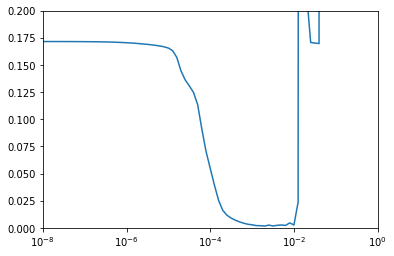

In [28]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1, 0, 0.2])

## Real training


In [45]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_img, decoded = ae_model('tanh')
autoencoder = Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(lr=2.5e-3)
autoencoder.compile(optimizer=optimizer, loss='mse')

model_name = 'model_3'
save_path='./' + model_name + '.hdf5'
model_cb=ModelCheckpoint(save_path, monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=50,verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            patience=5,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]
history=autoencoder.fit(X_train, y_train,
                        epochs=2000,
                        batch_size=32,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=cb)

l to ./model_3.hdf5
Epoch 1893/2000
50/50 [==============================] - 1s 24ms/step - loss: 2.4009e-05 - val_loss: 2.4008e-05

Epoch 01893: val_loss did not improve from 0.00002
Epoch 1894/2000
50/50 [==============================] - 1s 24ms/step - loss: 2.4102e-05 - val_loss: 2.3967e-05

Epoch 01894: val_loss improved from 0.00002 to 0.00002, saving model to ./model_3.hdf5
Epoch 1895/2000
50/50 [==============================] - 1s 24ms/step - loss: 2.4001e-05 - val_loss: 2.3947e-05

Epoch 01895: val_loss improved from 0.00002 to 0.00002, saving model to ./model_3.hdf5
Epoch 1896/2000
50/50 [==============================] - 1s 24ms/step - loss: 2.4013e-05 - val_loss: 2.3931e-05

Epoch 01896: val_loss improved from 0.00002 to 0.00002, saving model to ./model_3.hdf5
Epoch 1897/2000
50/50 [==============================] - 1s 23ms/step - loss: 2.3977e-05 - val_loss: 2.3990e-05

Epoch 01897: val_loss did not improve from 0.00002
Epoch 1898/2000
50/50 [=============================

## Save history


In [46]:
df_results = pd.DataFrame(history.history)
df_results['epoch'] = history.epoch
df_results.to_csv('./' + model_name + '.csv',index=False)

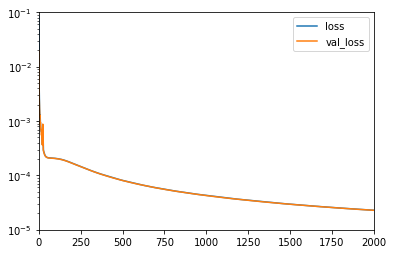

In [48]:
plt.semilogy(history.history['loss'], label='loss')
plt.semilogy(history.history['val_loss'], label='val_loss')
plt.axis([0, 2000, 1e-5, 1e-1])
plt.legend()
plt.show()

## Extract latent space and modes

In [49]:
model = load_model("model_3.hdf5")
model_reduced_1 = Model(inputs=model.input,
                      outputs=model.get_layer("conv2d_11").output)
model_reduced_2 = Model(inputs=model.input,
                      outputs=model.get_layer("conv2d_17").output)
model_coeff_1 = Model(inputs=model.input,
                    outputs=model.get_layer("lambda").output)
model_coeff_2 = Model(inputs=model.input,
                    outputs=model.get_layer("lambda_1").output)

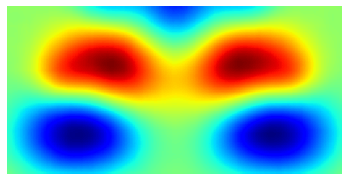

In [50]:
test = model_reduced_1.predict(dataset[np.newaxis, 0, :])
plt.imshow(test[0, :, :, 0], cmap='jet')
plt.axis('off')
# plt.savefig("q1.png")
plt.show()

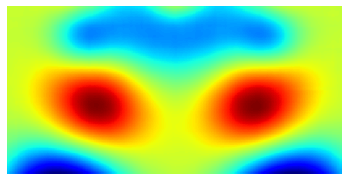

In [51]:
test = model_reduced_2.predict(dataset[np.newaxis, 0, :])
plt.imshow(test[0, :, :, 0], cmap='jet')
plt.axis('off')
# plt.savefig("q2.png")
plt.show()

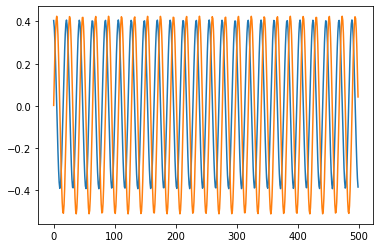

In [52]:
coeff_1 = model_coeff_1.predict(dataset)
coeff_2 = model_coeff_2.predict(dataset)

plt.plot(coeff_1[500:1000])
plt.plot(coeff_2[500:1000])
# plt.savefig("r1_r2.png")
plt.show()

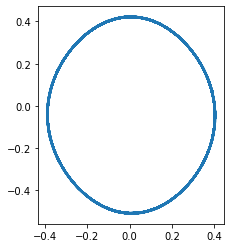

In [53]:
_, ax = plt.subplots(1)
ax.plot(coeff_1, coeff_2)
ax.set_aspect(1)
# plt.savefig("phase.png")
plt.show()

## POD

In [54]:
import sys
sys.path.append('/home/zhiyao/Vault/151_mrpod')
from mrpod import pod_modes

In [55]:
# v_array is the pre-generated dataset
pod_results = pod_modes(dataset, num_of_modes=2, normalize_mode=True)

# get the modes and projection coefficients
proj_coeffs = pod_results['proj_coeffs']
modes = pod_results['modes']
eigvals = pod_results['eigvals']
# normalize eigenvalues
eigvals = eigvals/eigvals.sum()*100

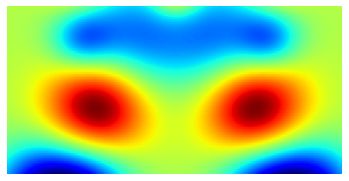

In [56]:
plt.imshow(modes[0, :, :, 0], cmap='jet')
plt.axis('off')
plt.show()

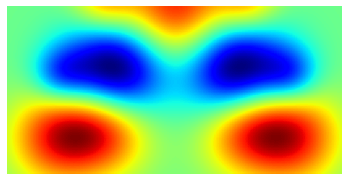

In [57]:
plt.imshow(modes[1, :, :, 0], cmap='jet')
plt.axis('off')
plt.show()

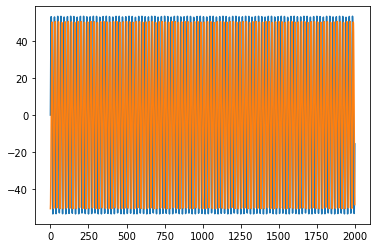

In [58]:
plt.plot(proj_coeffs[0, :])
plt.plot(proj_coeffs[1, :])
plt.show()

In [59]:
eigvals[:2]

array([52.74246123, 47.25753877])